# EDC 3: Ekimetrics - AI for Sustainability

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import numpy as np

## Import data

In [2]:
cities = pd.read_csv("data/cities.csv")
factors = pd.read_csv("data/factors.csv")
orders = pd.read_csv("data/orders.csv")
packages = pd.read_csv("data/packages.csv")
pricing = pd.read_csv("data/pricing.csv")
routes = pd.read_csv("data/routes_v2.csv")
trucks = pd.read_csv("data/trucks.csv")
warehouses = pd.read_csv("data/warehouses.csv")

#### 1- Cleaning routes

In [3]:
routes_cleaned = routes.copy()
routes_cleaned.stops = routes.apply(lambda x: x.stops.split(' > '), axis=1)
routes_cleaned.orders = routes.apply(lambda x: x.orders.split(' > '), axis=1)
routes_cleaned.head(1)

,truck_id,duration,fill_volume,n_units,orders,from_warehouse,route_date,stops,total_distance
0,jehwGBpNg2rDLeKoYeiaLs,2.167136,5.9879,87.0,"[nK4iPf8nrGA9yivRH66ehS, jnsH9ndQ3UKcWSbb2UMkFn]",Clermont-Ferrand,2021-01-02,"[Clermont-Ferrand, Bourges]",153.950611


In [4]:
packages_cleaned = packages.copy()

#On commence par corriger la valeur du package de volume buggé
packages_cleaned.loc[packages_cleaned['package_id']=='aBCDNfWx5TAkxbTTmQJEE4','package_volume'] = 0.1138

#On corrige tous les prix pour les accorder au pricing selon le volume - tient compte des missing values en price
packages_cleaned['threshold'] = packages_cleaned.apply(lambda x: min(pricing.max_volume.values, key=lambda y:max(0,x.package_volume-y)) ,axis=1)

packages_cleaned = pd.merge(packages_cleaned,pricing[['max_volume','pricing']], left_on='threshold', right_on='max_volume')
packages_cleaned.loc[packages_cleaned['package_revenues']!=packages_cleaned['pricing'],'package_revenues'] = packages_cleaned['pricing']

#On ne garde que les colonnes pertinentes
packages_cleaned = packages_cleaned[packages.columns]

## Questions répondues par la data:

#### 2-Les routes les plus empruntées

In [5]:
used_tracks = []
for i in range(len(routes_cleaned)):
    for j in range(len(routes_cleaned.stops[i])-1):
        used_tracks += [[routes_cleaned.stops[i][j] + ' - ' + routes_cleaned.stops[i][j+1],
                         routes_cleaned.stops[i][j],
                         routes_cleaned.stops[i][j+1],
                         routes_cleaned.route_date[i],
                        routes_cleaned.from_warehouse[i]]]
used_tracks = (pd.DataFrame(used_tracks,columns=['routes','start','stop','date', 'from_warehouse']))

# Daily analysis

In [6]:
# daily analysis
# we chose to study the day with the highest volume of packages to deliver

In [7]:
routes_used_per_day = (used_tracks
                       .groupby(['routes','date','start','stop', 'from_warehouse'])
                       .agg({'routes':'count'})
                       .rename(columns={'routes':'nb_routes'})
                       .sort_values("nb_routes"))

routes_used_per_day = routes_used_per_day.reset_index()

In [8]:
# first we draw the France on one day to see if we can improve our transportation netwok on a daily basis

In [9]:
day_routes = routes_used_per_day[routes_used_per_day['date']=='2021-05-10']

In [10]:
routes_used_day = (day_routes
               .groupby(['routes','start','stop', 'from_warehouse'])
               .agg({'routes':'count'})
               .rename(columns={'routes':'nb_routes'})
               .sort_values("nb_routes"))

routes_used_day = pd.merge(routes_used_day.reset_index(), cities[['city','lat','lng']], 
                       left_on='start',right_on='city')

routes_used_day = (routes_used_day
               .rename(columns={'lat':'lat_start','lng':'lng_start'})
               .drop(columns=['city']))

routes_used_day = pd.merge(routes_used_day.reset_index(), cities[['city','lat','lng']], 
                       left_on='stop',right_on='city')

routes_used_day = (routes_used_day
               .rename(columns={'lat':'lat_stop','lng':'lng_stop'})
               .drop(columns=['city']))

# OPTIMIZER

In [11]:
# building the dataframes on the chosen date 
routes_used_per_day = (used_tracks
                       .groupby(['routes','date','start','stop', 'from_warehouse'])
                       .agg({'routes':'count'})
                       .rename(columns={'routes':'nb_routes'})
                       .sort_values("nb_routes"))

routes_used_per_day = routes_used_per_day.reset_index()

In [12]:
day_routes = routes_used_per_day[routes_used_per_day['date']=='2021-05-10']

In [13]:
routes_used_day = (day_routes
               .groupby(['routes','start','stop', 'from_warehouse'])
               .agg({'routes':'count'})
               .rename(columns={'routes':'nb_routes'})
               .sort_values("nb_routes"))

routes_used_day = pd.merge(routes_used_day.reset_index(), cities[['city','lat','lng']], 
                       left_on='start',right_on='city')

routes_used_day = (routes_used_day
               .rename(columns={'lat':'lat_start','lng':'lng_start'})
               .drop(columns=['city']))

routes_used_day = pd.merge(routes_used_day.reset_index(), cities[['city','lat','lng']], 
                       left_on='stop',right_on='city')

routes_used_day = (routes_used_day
               .rename(columns={'lat':'lat_stop','lng':'lng_stop'})
               .drop(columns=['city']))

In [14]:
pck_volume_per_city = orders[orders['delivered_date']=='2021-05-10 00:00:00'].groupby('delivery_location').aggregate({'order_total_volume':'sum'}).sort_values('order_total_volume',ascending=False)
pck_volume_per_city = pd.merge(cities,pck_volume_per_city, left_on='city', right_index=True)

pck_volume_per_city['text'] = pck_volume_per_city['city'] + ', ' + 'total_order_volume: ' + round(pck_volume_per_city['order_total_volume']).astype(str)

In [15]:
# optimize roads on a daily basis
# we optimize for example the Cergy delivery network

In [16]:
cergy_routes = routes_used_day[routes_used_day['from_warehouse']=='Montauban']

In [17]:
pck_volume_per_city = orders[(orders['delivered_date']=='2021-05-10 00:00:00') & (orders['from_warehouse']=='Montauban')].groupby('delivery_location').aggregate({'order_total_volume':'sum'}).sort_values('order_total_volume',ascending=False)
pck_volume_per_city = pd.merge(cities,pck_volume_per_city, left_on='city', right_index=True)

pck_volume_per_city['text'] = pck_volume_per_city['city'] + ', ' + 'Package_Volume: ' + round(pck_volume_per_city['order_total_volume']).astype(str)

In [18]:
# what is our location and demand of each customer ?
demand_and_location=pd.DataFrame()

demand_and_location['latitude'] = pck_volume_per_city['lat']
demand_and_location['longitude'] = pck_volume_per_city['lng']
demand_and_location['demand'] = pck_volume_per_city['order_total_volume']
demand_and_location['city'] = pck_volume_per_city['city']

In [19]:
loca = warehouses.rename(columns={'warehouse_city':'city'}).merge(cities[['city', 'lat', 'lng']], on=['city'], how='left')

In [20]:
# set the depot as the center and make demand 0 ('0' = depot)
demand_and_location.loc[demand_and_location['city']=='Montauban', 'latitude'] = loca[loca['city']=='Montauban']['lat'].values
demand_and_location.loc[demand_and_location['city']=='Montauban', 'longitude'] = loca[loca['city']=='Montauban']['lng'].values
demand_and_location.loc[demand_and_location['city']=='Montauban','demand'] = 0

In [21]:
demand_and_location = demand_and_location.sort_values(by='demand', ascending=True)

In [22]:
demand_and_location = demand_and_location.reset_index()

del demand_and_location['index']

In [23]:
from math import radians, sin, cos, asin, acos, sqrt

In [24]:
# distance between two points
def distance_Haversine(lat1, lat2, lon1, lon2):

    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)

# function for calculating distance between two pins
def _distance_calculator(_df):
    
    _distance_result = np.zeros((len(_df),len(_df)))
    _df['latitude-longitude'] = '0'
    for i in range(len(_df)):
        _df['latitude-longitude'].iloc[i] = str(_df.latitude[i]) + ',' + str(_df.longitude[i])
    
    for i in range(len(_df)):
        for j in range(len(_df)):

            _res = distance_Haversine(_df['latitude'].iloc[i], _df['latitude'].iloc[j], _df['longitude'].iloc[i], _df['longitude'].iloc[j])
            
            # append distance to result list
            _distance_result[i][j] = _res
    
    return _distance_result



distance = _distance_calculator(demand_and_location)

/Users/ariane/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [25]:
import pyproj as proj

# setup your projections
crs_wgs = proj.Proj(init='epsg:4326') # assuming you're using WGS84 geographic
crs_bng = proj.Proj(init='epsg:27700') # use a locally appropriate projected CRS

/Users/ariane/anaconda3/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/ariane/anaconda3/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/Users/ariane/anaconda3/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

In [26]:
#Importing the package numpy as np.
import numpy as np

# Number of customers.
n = len(demand_and_location) - 1

#The set of nodes without the depot.
N = [i for i in range(1,n+1)]
# The set of nodes + the depot.
V = [0]+ N
# A collection that contains the demand of each node.
d ={i:demand_and_location.demand[i] for i in N}


# Generating random numbers between (0 and 15) * 200.
loc_x = [proj.transform(crs_wgs, crs_bng,demand_and_location.longitude[i], demand_and_location.latitude[i])[0] for i in N]
# Generating random numbers between (0 and 15) * 100.
loc_y = [proj.transform(crs_wgs, crs_bng,demand_and_location.longitude[i], demand_and_location.latitude[i])[1] for i in N]


loc_x = [proj.transform(crs_wgs, crs_bng,demand_and_location.longitude[0], demand_and_location.latitude[0])[0]] + loc_x
loc_y = [proj.transform(crs_wgs, crs_bng,demand_and_location.longitude[0], demand_and_location.latitude[0])[1]] + loc_y

/Users/ariane/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  app.launch_new_instance()
/Users/ariane/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
/Users/ariane/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
/Users/ariane/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1


In [27]:
dict_mapping = {demand_and_location['city'][i]: demand_and_location.index[i] for i in range(len(demand_and_location))}

In [28]:
edges_cergy_day = cergy_routes[['start', 'stop']]

edges_cergy_day['start'] = edges_cergy_day['start'].map(dict_mapping)
edges_cergy_day['stop'] = edges_cergy_day['stop'].map(dict_mapping)

/Users/ariane/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ariane/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [29]:
width_cergy_day = cergy_routes['nb_routes'].tolist()
edges_cergy = edges_cergy_day.values

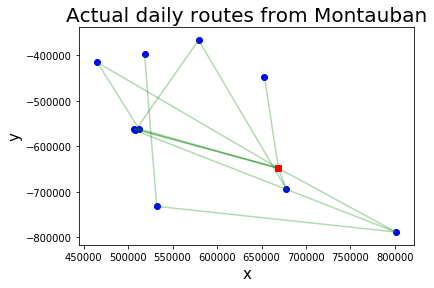

In [30]:
for item in edges_cergy :
  #Coloring the active arcs
  plt.plot([loc_x[item[0]],loc_x[item[1]]],[loc_y[item[0]],loc_y[item[1]]],c='g',alpha=0.3)

plt.plot(loc_x[0],loc_y[0],c='r' ,marker='s')
plt.scatter(loc_x[1:],loc_y[1:],c='b')


plt.title("Actual daily routes from Montauban", size=20)
plt.ylabel("y", size=15)
plt.xlabel("x", size=15)


plt.show()

In [31]:
# pip install ortools

In [32]:
A = [(i,j) for i in V for j in V if i!=j]
#Calculating the distance between each node.
c= {(i,j):np.hypot(loc_x[i]-loc_x[j],loc_y[i]-loc_y[j]) for i,j in A}


distance_matrixx = [[0]*len(demand_and_location)]*len(demand_and_location)


for key in c.keys():
    distance_matrixx[key[0]][key[1]]=c[key]

In [33]:
# [START program]
"""Capacited Vehicles Routing Problem (CVRP)."""

# [START import]
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
# [END import]


# [START data_model]
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = distance_matrixx[0:42][0:42]
    # [START demands_capacities]
    data['demands'] = demand_and_location.demand.astype(int).tolist()[0:42]
    data['vehicle_capacities'] = [128]*40
    # [END demands_capacities]
    data['num_vehicles'] = 40
    data['depot'] = 0
    return data
    # [END data_model]


# [START solution_printer]
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
#     print(f'Objective: {solution.ObjectiveValue()}')
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            plan_output += ' {0} Load({1}) -> '.format(node_index, route_load)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += ' {0} Load({1})\n'.format(manager.IndexToNode(index),
                                                 route_load)
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        plan_output += 'Load of the route: {}\n'.format(route_load)
#         print(plan_output)
        total_distance += route_distance
        total_load += route_load
#     print('Total distance of all routes: {}m'.format(total_distance))
#     print('Total load of all routes: {}'.format(total_load))
    return total_distance
    # [END solution_printer]

def get_edges(data, manager, routing, solution):
    """Prints solution on console."""

    route_vehicles = [[0]]*40

    for vehicle_id in range(data['num_vehicles']):

        index = routing.Start(vehicle_id)
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            if node_index!=0:
                route_vehicles[vehicle_id] = route_vehicles[vehicle_id] + [node_index]
            
            previous_index = index
            index = solution.Value(routing.NextVar(index))           

        manager.IndexToNode(index)
        
    return route_vehicles

def main():
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    # [START data]
    data = create_data_model()
    # [END data]

    # Create the routing index manager.
    # [START index_manager]
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])
    # [END index_manager]

    # Create Routing Model.
    # [START routing_model]
    routing = pywrapcp.RoutingModel(manager)

    # [END routing_model]

    # Create and register a transit callback.
    # [START transit_callback]
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    # [END transit_callback]

    # Define cost of each arc.
    # [START arc_cost]
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # [END arc_cost]

    # Add Capacity constraint.
    # [START capacity_constraint]
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(
        demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')
    # [END capacity_constraint]

    # Setting first solution heuristic.
    # [START parameters]
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    search_parameters.time_limit.FromSeconds(1)
    # [END parameters]

    # Solve the problem.
    # [START solve]
    solution = routing.SolveWithParameters(search_parameters)
    # [END solve]

    # Print solution on console.
    
    # [START print_solution]
    if solution:

        total_distance = print_solution(data, manager, routing, solution)
        
        print('----------****---------')
        
        resul = get_edges(data, manager, routing, solution)
        
        return resul,total_distance
    else :
        print('bugged')
    # [END print_solution]


if __name__ == '__main__':
    resul, total_distance = main()
# [END program]

----------****---------


In [34]:
def getting_opt_edges(resul):
    # getting the optimal edges
    opt_edges_cergy = []
    for item in resul:
        if len(item)>1:
            for k in range(len(item)-1):
                opt_edges_cergy+= [(item[k],item[k+1])]
    
    return opt_edges_cergy

In [35]:
opt_edges = getting_opt_edges(resul)
total_distance

2920286

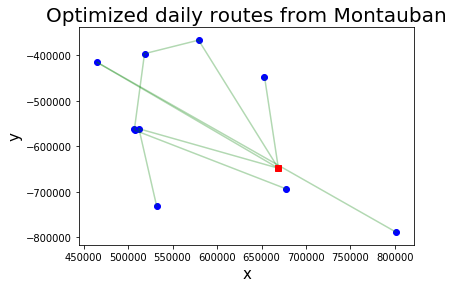

In [36]:
small_loc_x = loc_x[0:42]
small_loc_y = loc_y[0:42]

for item in opt_edges :
  #Coloring the active arcs
  plt.plot([loc_x[item[0]],loc_x[item[1]]],[loc_y[item[0]],loc_y[item[1]]],c='g',alpha=0.3)

plt.plot(loc_x[0],loc_y[0],c='r' ,marker='s')
plt.scatter(small_loc_x[1:],small_loc_y[1:],c='b')

plt.title("Optimized daily routes from Montauban", size=20)
plt.ylabel("y", size=15)
plt.xlabel("x", size=15)


plt.show()

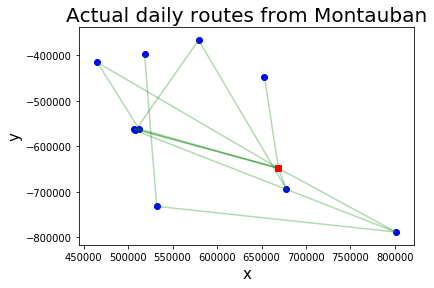

In [37]:
for item in edges_cergy :
  #Coloring the active arcs
  plt.plot([loc_x[item[0]],loc_x[item[1]]],[loc_y[item[0]],loc_y[item[1]]],c='g',alpha=0.3)

plt.plot(loc_x[0],loc_y[0],c='r' ,marker='s')
plt.title("Actual daily routes from Montauban", size=20)
plt.ylabel("y", size=15)
plt.xlabel("x", size=15)

plt.scatter(loc_x[1:],loc_y[1:],c='b')


plt.show()